<a href="https://colab.research.google.com/github/KavindaKGD/DL_Final_Assignment/blob/dev%2FMigara/LSTM_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
!nvidia-smi

Sat Oct 11 17:47:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             35W /   70W |     286MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [157]:
# Basic libraries
import os, glob, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [158]:
# Deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.metrics import classification_report, confusion_matrix

In [159]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [160]:
!unzip -q "/content/drive/MyDrive/street_building_dataset.zip" -d "/content/dataset"

replace /content/dataset/street_building_dataset/test/buildings/20057.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [161]:
import os
for root, dirs, files in os.walk("/content/dataset/street_building_dataset"):
    print(root, "->", len(files), "files")

/content/dataset/street_building_dataset -> 0 files
/content/dataset/street_building_dataset/train -> 0 files
/content/dataset/street_building_dataset/train/buildings -> 2191 files
/content/dataset/street_building_dataset/train/streets -> 2382 files
/content/dataset/street_building_dataset/test -> 0 files
/content/dataset/street_building_dataset/test/buildings -> 437 files
/content/dataset/street_building_dataset/test/streets -> 501 files


In [162]:
DATA_ROOT = "/content/dataset/street_building_dataset"

In [163]:
from PIL import Image
import os

def remove_corrupt_images(directory):
    removed = 0
    for root, _, files in os.walk(directory):
        for file in files:
            path = os.path.join(root, file)
            try:
                img = Image.open(path)
                img.verify()
            except (IOError, SyntaxError):
                print("Removing:", path)
                os.remove(path)
                removed += 1
    print(f"Removed {removed} corrupt images")

remove_corrupt_images("/content/dataset/street_building_dataset/train")
remove_corrupt_images("/content/dataset/street_building_dataset/test")

Removed 0 corrupt images
Removed 0 corrupt images


In [164]:
import tensorflow as tf

IMG_H, IMG_W = 150, 150
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/street_building_dataset/train",
    labels="inferred",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/street_building_dataset/test",
    labels="inferred",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 4573 files belonging to 2 classes.
Found 938 files belonging to 2 classes.
Classes: ['buildings', 'streets']


In [165]:
AUTOTUNE = tf.data.AUTOTUNE

def color_to_seq(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    shape = tf.shape(images)
    images = tf.reshape(images, (shape[0], shape[1], shape[2]*3))
    return images, labels

train_ds = train_ds.map(color_to_seq).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(color_to_seq).cache().prefetch(AUTOTUNE)

In [166]:
from tensorflow.keras import layers, models, Input

timesteps = IMG_H
features = IMG_W * 3

inputs = Input(shape=(timesteps, features))
x = layers.LSTM(128)(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150, 450)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,769 (1.16 MB)

 Trainable params: 304,769 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [167]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_lstm.keras", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5266 - loss: 0.7071 - val_accuracy: 0.6333 - val_loss: 0.6525
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5558 - loss: 0.6886 - val_accuracy: 0.5800 - val_loss: 0.6760
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5829 - loss: 0.6758 - val_accuracy: 0.6471 - val_loss: 0.6411
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6117 - loss: 0.6529 - val_accuracy: 0.6237 - val_loss: 0.6590
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5987 - loss: 0.6692 - val_accuracy: 0.6269 - val_loss: 0.6549
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6217 - loss: 0.6618 - val_accuracy: 0.6013 - val_loss: 0.6724
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6001 - loss: 0.6628 - val_accuracy: 0.6567 - val_loss: 0.6399
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6524 - loss: 0.6358 - val_accu

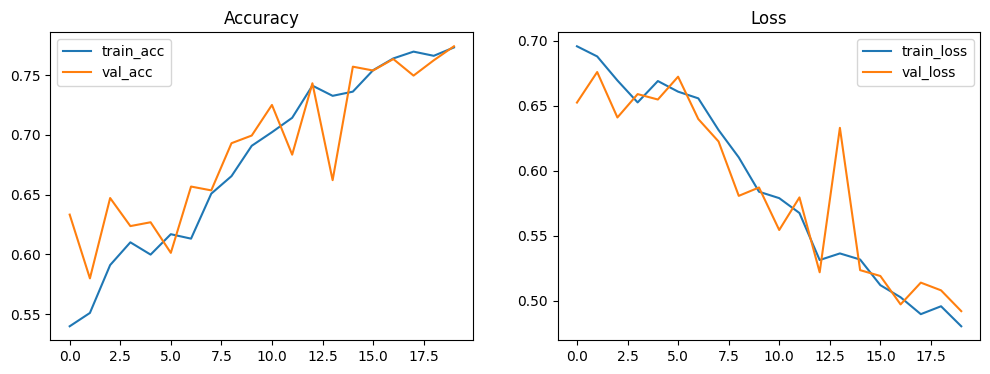

In [168]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()

In [169]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.3f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7703 - loss: 0.4730
Test Accuracy: 0.774


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

   buildings       0.76      0.75      0.76       437
     streets       0.79      0.79      0.79       501

    accuracy                           0.77       938
   macro avg       0.77      0.77      0.77       938
weighted avg       0.77      0.77      0.77       938



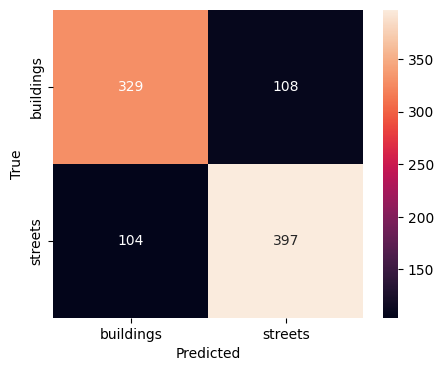

In [170]:
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_prob = model.predict(test_ds)
y_pred = (y_prob.flatten() >= 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

In [171]:
model.save("/content/drive/MyDrive/best_lstm_street_building.keras")

In [172]:
!unzip -q "/content/dataset/pred.zip" -d "/content/dataset/pred"

replace /content/dataset/pred/pred/20057.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [173]:
pred_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/pred",
    labels=None,
    image_size=(IMG_H, IMG_W),
    batch_size=32,
    shuffle=False
)

# Apply same preprocessing as training
def color_to_seq_pred(images):
    images = tf.cast(images, tf.float32) / 255.0
    shape = tf.shape(images)
    images = tf.reshape(images, (shape[0], shape[1], shape[2]*3))
    return images

pred_ds = pred_ds.map(color_to_seq_pred).cache()

Found 938 files.


In [174]:
pred_prob = model.predict(pred_ds)
pred_class = (pred_prob.flatten() >= 0.5).astype(int)
pred_labels = [class_names[i] for i in pred_class]

for i, label in enumerate(pred_labels[:50]):
    print(f"Image {i+1}: {label} (prob={pred_prob[i][0]:.2f})")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Image 1: buildings (prob=0.17)
Image 2: buildings (prob=0.19)
Image 3: buildings (prob=0.04)
Image 4: buildings (prob=0.04)
Image 5: streets (prob=0.66)
Image 6: streets (prob=0.87)
Image 7: streets (prob=0.86)
Image 8: streets (prob=0.80)
Image 9: buildings (prob=0.15)
Image 10: buildings (prob=0.06)
Image 11: streets (prob=0.87)
Image 12: buildings (prob=0.11)
Image 13: streets (prob=0.70)
Image 14: streets (prob=0.91)
Image 15: streets (prob=0.73)
Image 16: streets (prob=0.88)
Image 17: buildings (prob=0.07)
Image 18: streets (prob=0.93)
Image 19: buildings (prob=0.05)
Image 20: streets (prob=0.81)
Image 21: buildings (prob=0.47)
Image 22: streets (prob=0.86)
Image 23: streets (prob=0.85)
Image 24: buildings (prob=0.31)
Image 25: streets (prob=0.90)
Image 26: buildings (prob=0.08)
Image 27: buildings (prob=0.40)
Image 28: buildings (prob=0.40)
Image 29: streets (prob=0.86)
Image 30: buildings (prob=0.41)
Image 31: buildings (prob=0.09)
Image 3

Found 938 files.


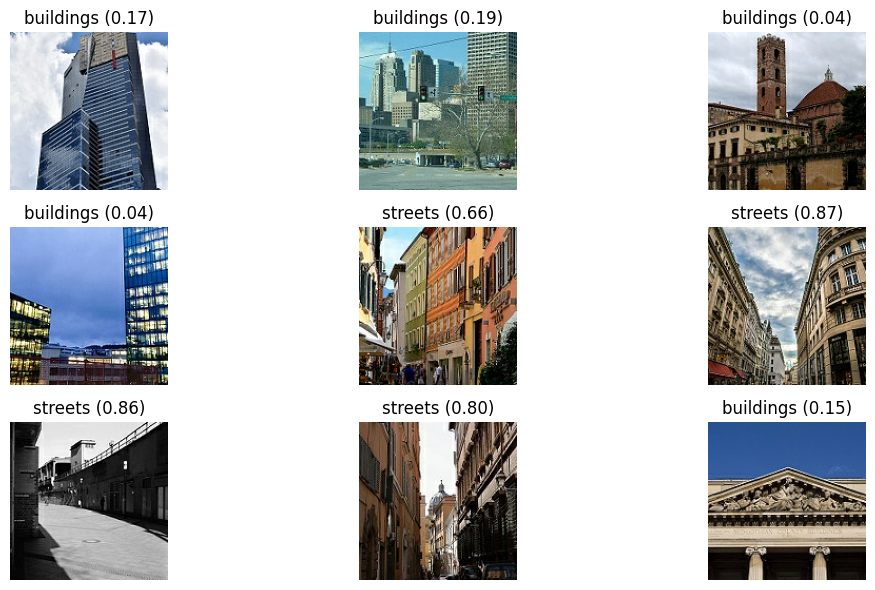

In [175]:
import matplotlib.pyplot as plt

# Load original RGB images for display
raw_pred_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/pred",
    labels=None,
    image_size=(IMG_H, IMG_W),
    batch_size=9,
    shuffle=False
)

for images in raw_pred_ds.take(1):
    imgs = images.numpy().astype("uint8")

plt.figure(figsize=(12,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs[i])
    plt.title(f"{pred_labels[i]} ({pred_prob[i][0]:.2f})")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [176]:
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(image_path):
    img = load_img(image_path, target_size=(IMG_H, IMG_W))
    img_array = img_to_array(img) / 255.0
    img_array = tf.reshape(img_array, (1, IMG_H, IMG_W * 3))

    pred_prob = model.predict(img_array)[0][0]
    pred_class = 1 if pred_prob >= 0.5 else 0
    print(f"Predicted class: {class_names[pred_class]} (prob={pred_prob:.3f})")

# Example:
predict_image("/content/dataset/pred/pred/20083.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted class: streets (prob=0.739)
